## Практическая работа к занятию №5

Попробуйте обучить нейронную сеть LSTM на любом другом датасете

В качестве датасета возьмем следующий временной ряд:<br>https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv

Датасет содержит среднесуточные значения температуры начиная с 1750 до 2015 года.
Мы усредним эти значения по годам и будем пытаться спрогнозировать температуру в следующем году

Исследуем влияние количества годов, используемых для прогноза, а также количество нейронов в LSTM слое



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Flatten, LSTM)
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
!nvidia-smi

Thu Feb 17 22:58:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Подготовка данных

In [64]:
df = pd.read_csv('/content/GlobalTemperatures.csv')
df = df[['dt', 'LandAverageTemperature']]
print(f'Количество дней в датасете: {df.shape[0]}')
df.head()

Количество дней в датасете: 3192


,dt,LandAverageTemperature
0,1750-01-01,3.034
1,1750-02-01,3.083
2,1750-03-01,5.626
3,1750-04-01,8.490
4,1750-05-01,11.573


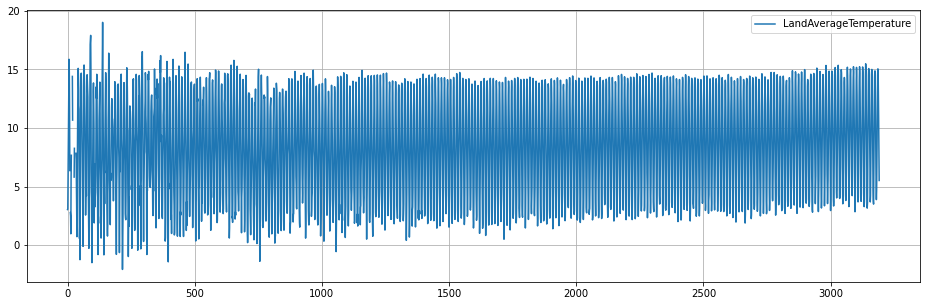

In [65]:
df.plot(figsize = (16,5))
plt.grid('On')
plt.show()

Усредним суточные значения температуры по годам

In [66]:
years = np.unique(df['dt'].apply(lambda x: x[:4]))
mean_year_temp = []
for year in years:
    mean_year_temp.append(df[df['dt'].apply(
        lambda x: x[:4]) == year]['LandAverageTemperature'].mean())
df = pd.DataFrame(data={'year': np.arange(len(years)),
                        'temp': mean_year_temp})
df.index = df['year']
df.drop(['year'],axis=1,inplace = True)
df.head()

,temp
year,
0,8.719364
1,7.976143
2,5.779833
3,8.388083
4,8.469333


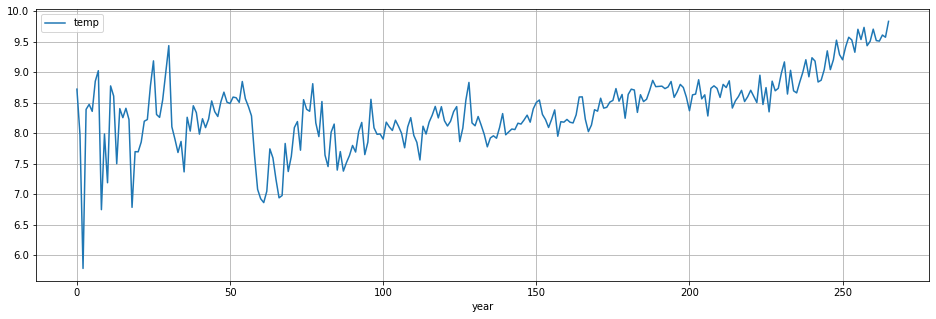

In [67]:
df.plot(figsize = (16,5))
plt.grid('On')
plt.show()

In [68]:
class TimeSeriesData:
    def __init__(self, df, xLen, train_split=220, bias=0,
                 target_col='temp', batch_size=32):
        """
        df - исходный датасет
        train_split - длина трейна
        xLen - длина истории для работы
        bias - отступ тестов от тренировок
        """
        self.df = df
        self.xLen = xLen
        self.train_split = train_split
        self.bias = bias
        self.target = target_col
        self.batch_size = 32
        self.scaler = StandardScaler()

        self.train_data, self.val_data = self.custom_train_split()
        self.scale_train, self.scale_val = self.std_scaler()
        self.train_gen, self.val_gen = self.get_generators()

    def custom_train_split(self):
        train_data = self.df.iloc[0 : self.train_split,]
        val_data = self.df.iloc[self.train_split + self.bias:,]

        return train_data, val_data

    def std_scaler(self):
        self.scaler.fit(self.train_data[[self.target]])
        
        scale_train = self.train_data.copy()
        scale_val = self.val_data.copy()

        scale_train[[self.target]] = self.scaler.transform(self.train_data[[self.target]])
        scale_val[[self.target]] = self.scaler.transform(self.val_data[[self.target]])

        return scale_train, scale_val

    def get_generators(self):
        train_gen = TimeseriesGenerator(self.train_data.values,
                                        self.train_data.values,
                                        length=self.xLen,
                                        sampling_rate=1,
                                        batch_size=self.batch_size)
        val_gen = TimeseriesGenerator(self.val_data.values,
                                      self.val_data.values,
                                      length=self.xLen,
                                      sampling_rate=1,
                                      batch_size=self.batch_size)
        return train_gen, val_gen

In [69]:
xLen=14
train_split=220
bias=0
target_col='temp'
batch_size=32

time_series_data = TimeSeriesData(df, xLen=xLen, train_split=train_split,
                                  bias=bias, target_col=target_col,
                                  batch_size=batch_size)

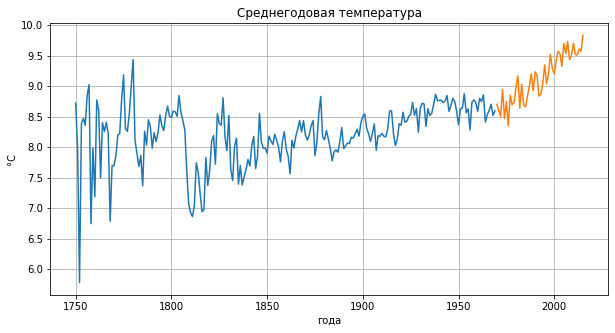

In [70]:
plt.figure(figsize=(10,5))
train_len = len(time_series_data.train_data['temp'])
years = list(map(int, years))
plt.plot(years[:train_len],
         time_series_data.train_data['temp'])
plt.plot(years[train_len:],
         time_series_data.val_data['temp'])
plt.grid('on')
plt.xlabel('года')
plt.ylabel('°C')
plt.title('Среднегодовая температура')
plt.show()

In [112]:
def create_model(train_gen, lstm_units):
    batch_0 = train_gen[0]
    x, y = batch_0

    model = Sequential()

    model.add(LSTM(lstm_units, input_shape=(x.shape[1], x.shape[2]),
                   return_sequences="True"))
    model.add(Flatten())
    model.add(Dense(64, activation="linear"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss="mse", optimizer=Adam(learning_rate=0.0005),
                  metrics=['mae'])

    return model

In [113]:
def train_model(train_gen, val_gen, lstm_units, epochs=100):
    model = create_model(train_gen, lstm_units)
    
    # callbaсk = EarlyStopping(monitor='val_mae', patience=10, verbose=1)
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=0)
        # callbacks=[callbaсk])
    train_logs = model.evaluate(train_gen, verbose=0)
    test_logs = model.evaluate(val_gen, verbose=0)
    return {
        'model': model,
        'history': history.history,
        'train_mae': train_logs[1],
        'val_mae': test_logs[1]
    }

In [114]:
train_split=220
bias=0
target_col='temp'
batch_size=32

lstm_units_grid = [32, 64, 128]
xLen_grid = [7, 14, 21]

results = {}

for xLen in xLen_grid:
    for lstm_units in lstm_units_grid:
        print(f"\txLen: {xLen}_lstm: {lstm_units}")
        time_series_data = TimeSeriesData(df, xLen=xLen, train_split=train_split,
                                        bias=bias, target_col=target_col,
                                        batch_size=batch_size)

        res = train_model(time_series_data.train_gen,
                          time_series_data.val_gen,
                          lstm_units=lstm_units)

        res['xLen'] = xLen
        res['lstm_units'] = lstm_units
        res['time_series_data'] = time_series_data
         
        results[f"xLen: {xLen}_lstm: {lstm_units}"] = res

	xLen: 7_lstm: 32
	xLen: 7_lstm: 64
	xLen: 7_lstm: 128
	xLen: 14_lstm: 32
	xLen: 14_lstm: 64
	xLen: 14_lstm: 128
	xLen: 21_lstm: 32
	xLen: 21_lstm: 64
	xLen: 21_lstm: 128


In [115]:
df_results = pd.DataFrame.from_dict(results, orient='index',
                                    columns=['train_mae', 'val_mae'])
df_results.sort_values(by='val_mae', inplace=True)
df_results

,train_mae,val_mae
xLen: 14_lstm: 128,0.268295,0.379962
xLen: 21_lstm: 128,0.262853,0.410579
xLen: 7_lstm: 64,0.287426,0.501297
xLen: 7_lstm: 128,0.278682,0.502421
xLen: 14_lstm: 64,0.279020,0.521422
xLen: 14_lstm: 32,0.294649,0.685483
xLen: 21_lstm: 32,0.279916,0.727421
xLen: 21_lstm: 64,0.312705,0.748678
xLen: 7_lstm: 32,0.335999,0.823922


Посмотрим на результат лучшей модели

In [116]:
def plot_mae(history):
    plt.plot(history['mae'][1:], 
            label='MAE на обучающем наборе')
    plt.plot(history['val_mae'][1:], 
            label='MAE на проверочном наборе')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [117]:
def plot_predict(result):
    model = result['model']
    series_data = result['time_series_data']
    xLen = result['xLen']

    predTrain = model.predict(series_data.train_gen).flatten()
    predVal = model.predict(series_data.val_gen).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))

    ax1.plot(predTrain, label='Прогноз')
    ax1.plot(series_data.train_data['temp'].values[xLen:], label='Базовый ряд')
    ax1.set_xlabel('Год')
    ax1.set_ylabel('Температура, °C')
    ax1.legend()

    ax2.plot(predVal, label='Прогноз')
    ax2.plot(series_data.val_data['temp'].values[xLen:], label='Базовый ряд')
    ax2.set_xlabel('Год')
    ax2.set_ylabel('Температура, °C')    
    ax2.legend()
    
    plt.show()

In [118]:
best_model = df_results.index[0]
print(best_model)

xLen: 14_lstm: 128


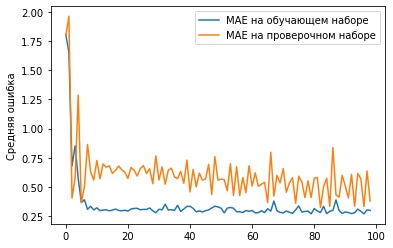

In [119]:
plot_mae(results[best_model]['history'])

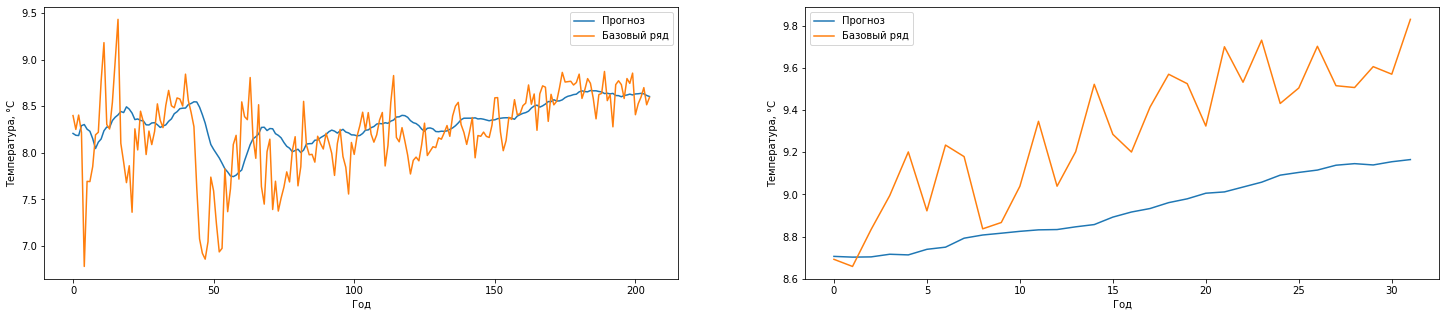

In [120]:
plot_predict(results[best_model])

Выводы:
1. Лучшая модель достаточно хорошо обучилась. Она смогла уловить тренд на повышение среднегодовой температуры в последние 30 лет (1985 - 2015)
2. Увеличение нейронов в LSTM слое приводит к улучшению качества модели
3. Оптимальное число лет для предсказания температуры в следующем году: 14

Построим подобный график для каждой полученной модели

################################################## xLen: 14_lstm: 128 ##################################################


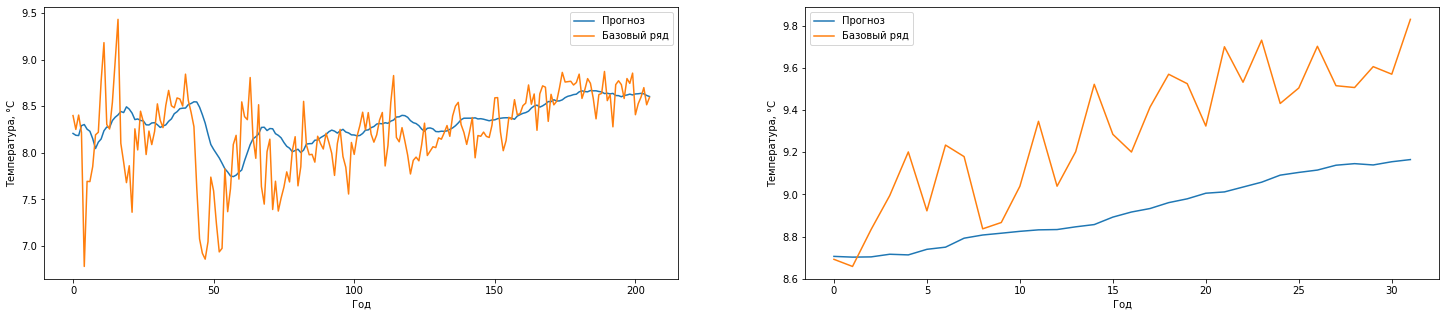

################################################## xLen: 21_lstm: 128 ##################################################


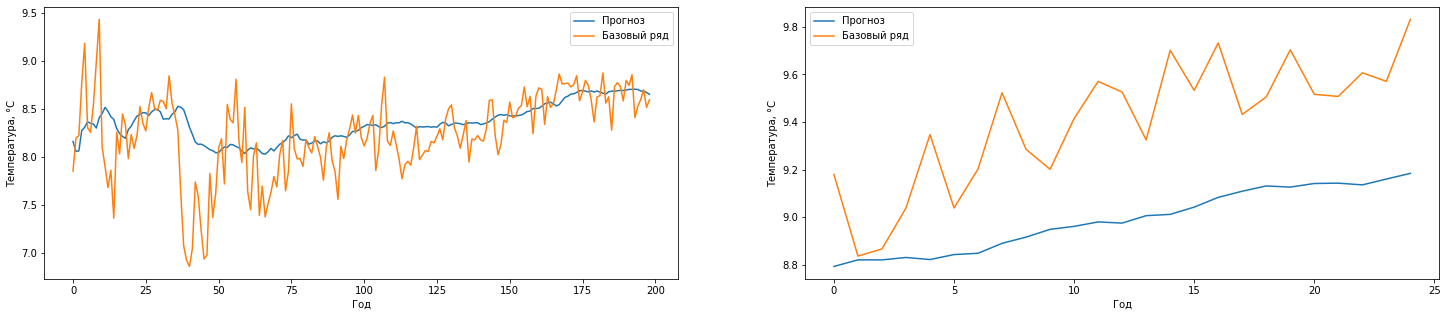

################################################## xLen: 7_lstm: 64 ##################################################


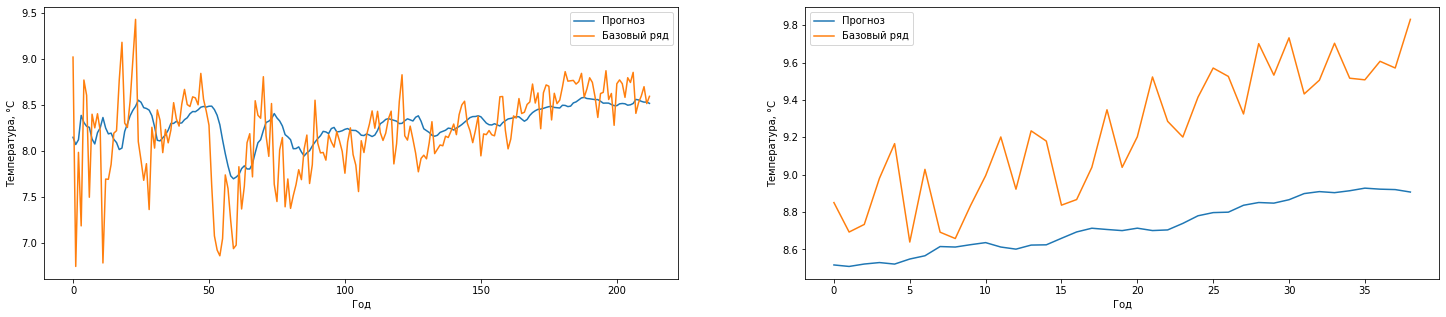

################################################## xLen: 7_lstm: 128 ##################################################


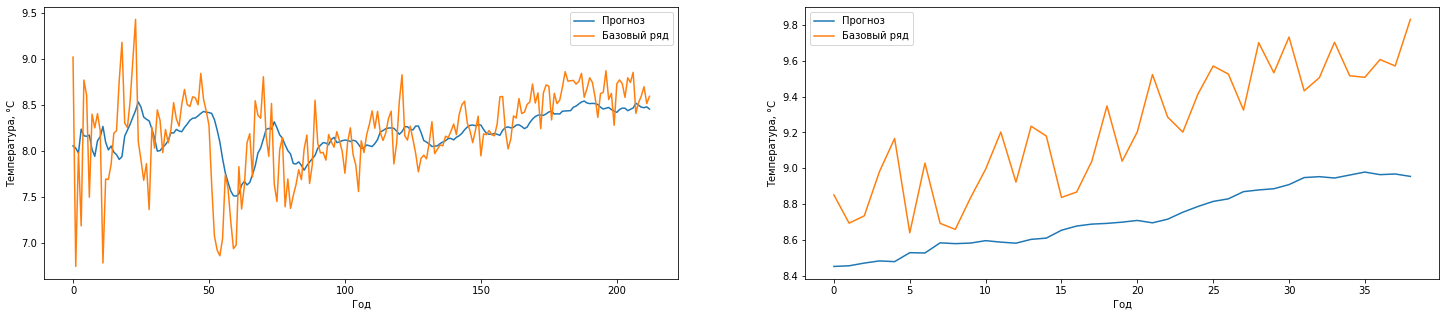

################################################## xLen: 14_lstm: 64 ##################################################


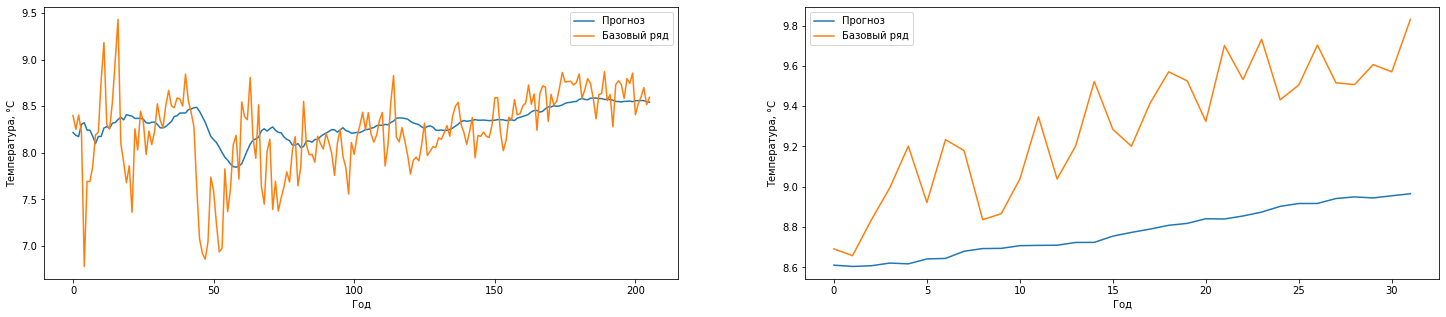

################################################## xLen: 14_lstm: 32 ##################################################


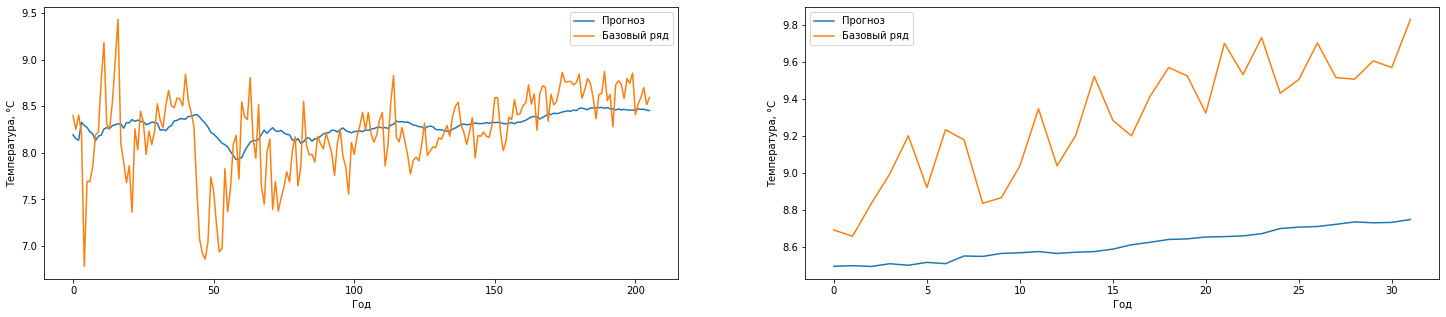

################################################## xLen: 21_lstm: 32 ##################################################


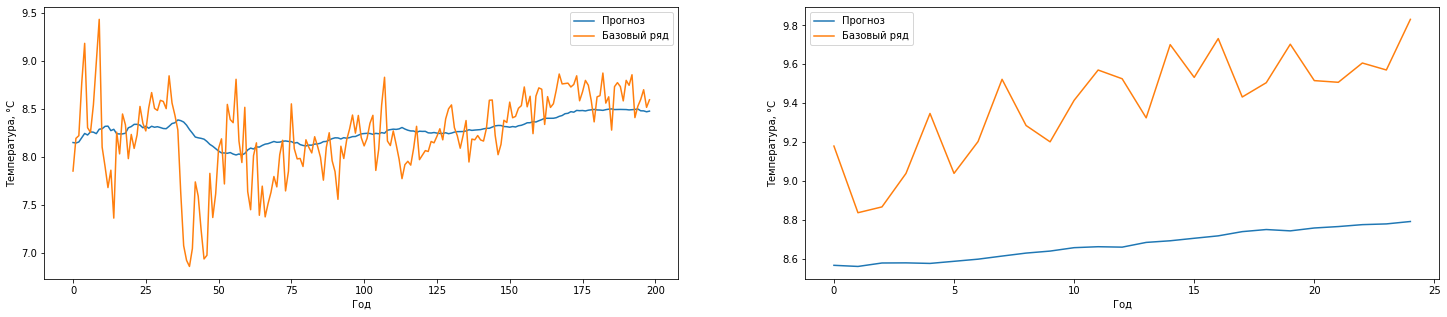

################################################## xLen: 21_lstm: 64 ##################################################


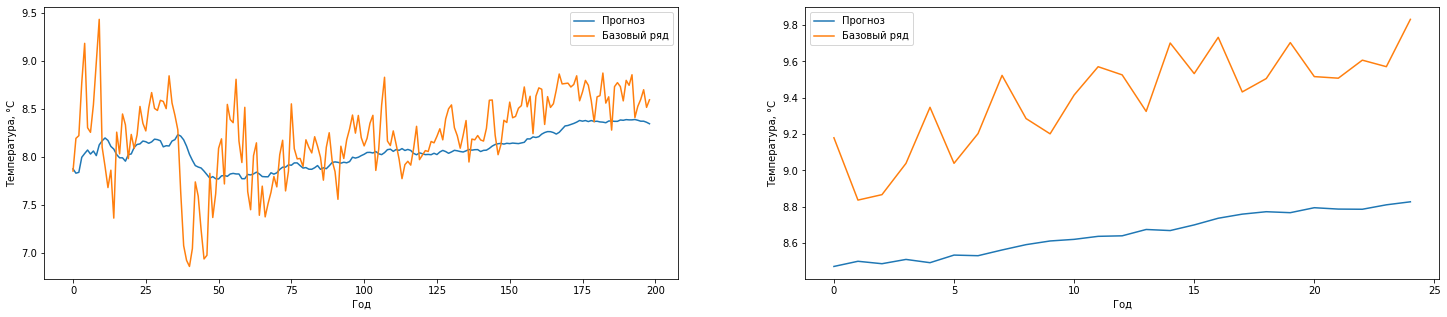

################################################## xLen: 7_lstm: 32 ##################################################


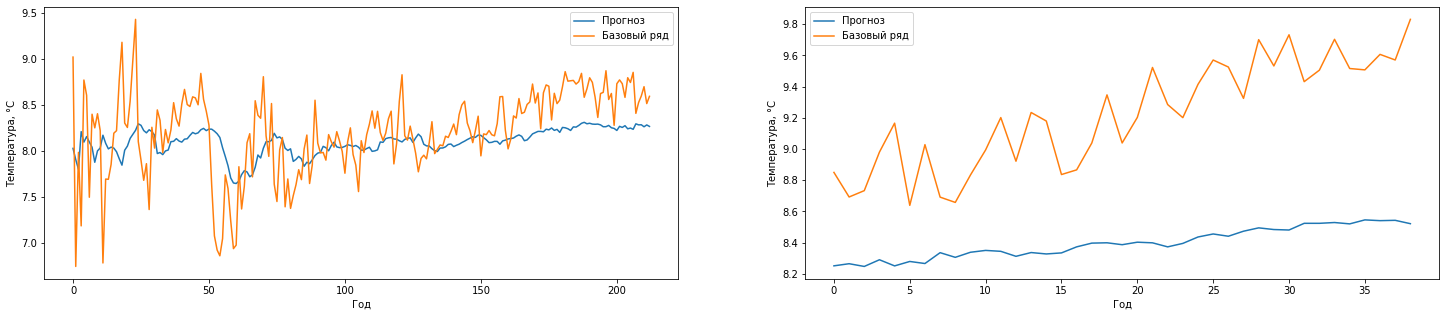

In [121]:
for model_name in df_results.index:
    print('#'*50, model_name, '#'*50)
    plot_predict(results[model_name])